In [1]:
# Vincular colab con Drive, seleccionar el link de abajo, seleccionar la cuenta y copiar el codigo en la casilla
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


La base de datos cats vs. dogs, se encuentra en el sitio https://www.kaggle.com/c/dogs-vs-cats/data y fue publicada por el sitio https://www.kaggle.com/ en el 2013 como parte de una competencia de visión computacional. Contiene un total de 25,000 imágenes, 12,500 de gatos y 12,500 de perros. En nuestro caso, usaremos un subconjunto de dicha base de datos.

In [2]:
import os, shutil
import zipfile

# Extracción de la base de datos desde el repositorio de Google Drive
local_zip = '/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Copia de cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [3]:
import os
# Carpeta virtual de colab donde se almacena la base de datos descargada
base_dir = '/content/cats_and_dogs_filtered'

# Carpetas donde se almacenan los conjuntos de entrenamiento y validación
train_dir = os.path.join(base_dir, 'train') # '/content/drive/My Drive/CNNs/cats_and_dogs_filtered/train'
validation_dir = os.path.join(base_dir, 'validation') # '/content/drive/My Drive/CNNs/cats_and_dogs_filtered/validation'

# Carpeta donde se almacenan las imágenes de gatos del conjunto de entrenamiento
train_cats_dir = os.path.join(train_dir, 'cats') #'/content/drive/My Drive/CNNs/cats_and_dogs_filtered/train/cats'

# Carpeta donde se almacenan las imágenes de perros del conjunto de entrenamiento
train_dogs_dir = os.path.join(train_dir, 'dogs') #'/content/drive/My Drive/CNNs/cats_and_dogs_filtered/train/dogs'

# Carpeta donde se almacenan las imágenes de gatos del conjunto de validación
validation_cats_dir = os.path.join(validation_dir, 'cats') # '/content/drive/My Drive/CNNs/cats_and_dogs_filtered/validation/cats'

# Carpeta donde se almacenan las imágenes de perros del conjunto de validación
validation_dogs_dir = os.path.join(validation_dir, 'dogs') # # '/content/drive/My Drive/CNNs/cats_and_dogs_filtered/validation/dogs'

In [4]:
print('Número de imágenes de gatos pertencientes al conjunto de entrenamiento:', len(os.listdir(train_cats_dir))) # Funcion que permite enumerar los archivos de una carpeta

Número de imágenes de gatos pertencientes al conjunto de entrenamiento: 1000


In [5]:
print('Número de imágenes de perros pertencientes al conjunto de entrenamiento:', len(os.listdir(train_dogs_dir)))

Número de imágenes de perros pertencientes al conjunto de entrenamiento: 1000


In [6]:
print('Número de imágenes de gatos pertencientes al conjunto de validación:', len(os.listdir(validation_cats_dir)))

Número de imágenes de gatos pertencientes al conjunto de validación: 500


In [7]:
print('Número de imágenes de perros pertencientes al conjunto de validación::', len(os.listdir(validation_dogs_dir)))

Número de imágenes de perros pertencientes al conjunto de validación:: 500


# **Construcción de la CNN**

In [8]:
from tensorflow.keras import layers
from tensorflow.keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

# **Compilación**

In [10]:
from tensorflow.keras import optimizers
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc']) # acc -> accuracy

# **Preprocesamiento de las imágenes de entrada**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Sirve para acceder y manipular las instancias de la base de datos

#Todas las imágenes se normalizan en el rango de [0,1]
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Carpeta del conjunto de entrenamiento, automaticamente categoriza las clases
        train_dir,
        # Las imágenes se redimensionan a 150 X 150
        target_size=(150, 150),
        batch_size=20,
        # Mediante el argumento class_mode, se define el tipo de clasificación que se llevará a cabo. En este caso, es clasificación binaria.
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [12]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


# **Entrenamiento**

In [13]:
history = model.fit(
      train_generator,     # Conjunto de entrenamiento
      steps_per_epoch=100, # Número de veces que se tomarán 20 (batch_size) lotes de imágenes
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 23s 85ms/step - loss: 0.6925 - acc: 0.5335 - val_loss: 0.6700 - val_acc: 0.6180
Epoch 2/30
100/100 [==============================] - 8s 85ms/step - loss: 0.6594 - acc: 0.6140 - val_loss: 0.6507 - val_acc: 0.6170
Epoch 3/30
100/100 [==============================] - 9s 89ms/step - loss: 0.6261 - acc: 0.6445 - val_loss: 0.6037 - val_acc: 0.6920
Epoch 4/30
100/100 [==============================] - 9s 92ms/step - loss: 0.5717 - acc: 0.6940 - val_loss: 0.5735 - val_acc: 0.7050
Epoch 5/30
100/100 [==============================] - 9s 93ms/step - loss: 0.5368 - acc: 0.7215 - val_loss: 0.5808 - val_acc: 0.6940
Epoch 6/30
100/100 [==============================] - 9s 87ms/step - loss: 0.5119 - acc: 0.7440 - val_loss: 0.5538 - val_acc: 0.6990
Epoch 7/30
100/100 [==============================] - 9s 93ms/step - loss: 0.4773 - acc: 0.7640 - val_loss: 0.5649 - val_acc: 0.7150
Epoch 8/30
100/100 [==============================] - 9s 94ms/step -

In [ ]:
# Guardar modelo en Drive
model.save('/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Modelo_cats_and_dogs_small_1.h5')

In [29]:
# Cargar un modelo previamente cargado o guardado en Drive
from tensorflow.keras.models import load_model
model_saved = load_model('/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Modelo_cats_and_dogs_small_1.h5', compile=False)

# **Curvas de precisión y pérdida**

Mejor época (exactitud)  16
Mejor época (pérdida)  11


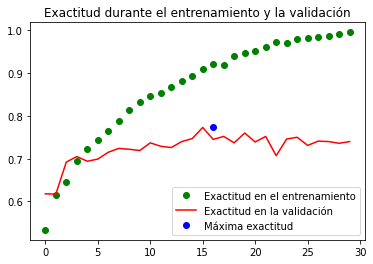

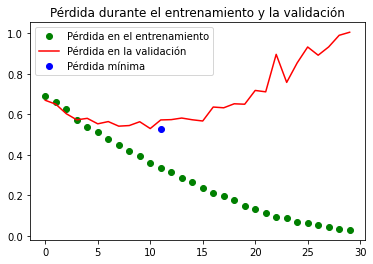

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
max_val_acc_epoch= val_acc.index(max(val_acc)) + 1
loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Exactitud en el entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Exactitud en la validación')
plt.plot(max_val_acc_epoch, max_val_acc, 'bo', label='Máxima exactitud')
plt.title('Exactitud durante el entrenamiento y la validación')
plt.legend()
print('Mejor época (exactitud) ', max_val_acc_epoch)
plt.figure()

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Pérdida mínima')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print('Mejor época (pérdida) ', min_val_loss_epoch)

plt.show()

# **Aumentación de datos**

Mediante el proceso de aumentación de datos, Keras brinda la posibilidad de incrementar el número de imágenes del conjunto de entrenamiento, a través de la generación de imágenes sintéticas.<br> 
Algunas de las transformaciones para aumentación de datos, son las siguientes:<br>
°**rotation_range =** Orientación aleatoria de las imágenes en el rango de 0-180.<br>
°**width_shift_range/height_shift_range =** Traslación horizontal/vertical de las imágenes en un rango aleatorio determinado. Este rango está delimitado por las dimensiones de la imagen.<br>
°**shear_range =** Ángulo aleatorio de inclinación de la imagen. A diferencia de la rotación, en shear_range se deja fijo un eje y a partir de este, se realiza la inclinación. Visualmente, esta transformación da la impresión de estirar la imagen.<br>
°**zoom_range =** Zoom aleatorio a la imagen.<br>
°**horizontal_flip =** Cuando su valor es de True, la mitad de las imágenes se voltean horizontalmente. Las imágenes que se voltean se eligen de forma aleatoria.<br>
°**fill_mode =** Estrategia para rellenar las zonas de la imagen que quedan vacías al aplicar transformaciones como rotation_range o width_shift_range/height_shift_range.


Para tener mayor informacion sobre tecnicas de aumentacion de datos, podemos buscar en:
https://keras.io/api/preprocessing/image/

In [15]:
# Funcion que permite cambiar la imagen totalmente
datagen = ImageDataGenerator(
      rotation_range=40,       # Rotar la imagen 40°
      width_shift_range=0.2,   # Traslacion de la imagen en ancho
      height_shift_range=0.2,  # Traslacion de imagen en largo
      shear_range=0.2,         # Inclinar la imagen
      zoom_range=0.2,          # Crear zoom a la imagen
      horizontal_flip=True,    # Voltear la imagen horizontalmente
      fill_mode='nearest')

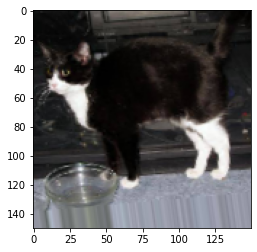

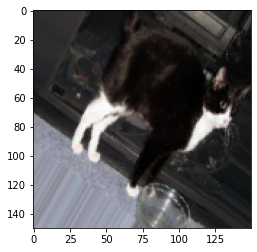

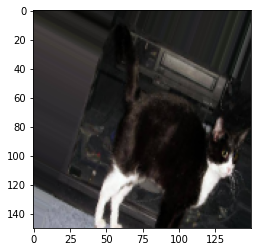

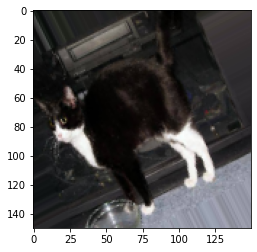

In [16]:
# Este módulo de Keras permite procesar imágenes
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# Elegimos una imagen para aumentar
img_path = fnames[3]

# Leemos y redimensionamos la imagen
img = image.load_img(img_path, target_size=(150, 150))

# Convertimos la imagen a un numpy array con dimensiones (150, 150, 3)
x = image.img_to_array(img)

# Redimensionamos el array a (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# El comando flow () genera lotes de imágenes transformadas de forma aleatoria.
# Este flujo es infinito, así que tenemos que terminarlo explícitamente.
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [17]:
datagen = ImageDataGenerator(
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      #shear_range=0.7)
      zoom_range=0.8)
      #horizontal_flip=True
      #fill_mode='nearest')

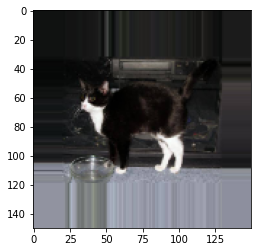

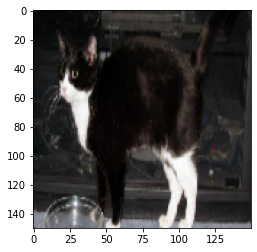

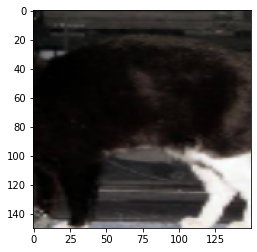

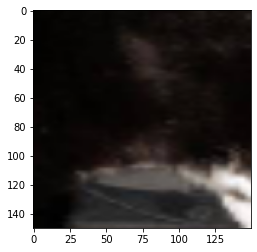

In [18]:
# Este módulo de Keras permite procesar imágenes
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# Elegimos una imagen para aumentar
img_path = fnames[3]

# Leemos y redimensionamos la imagen
img = image.load_img(img_path, target_size=(150, 150))

# Convertimos la imagen a un numpy array con dimensiones (150, 150, 3)
x = image.img_to_array(img)

# Redimensionamos el array a (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# El comando flow () genera lotes de imágenes transformadas de forma aleatoria.
# Este flujo es infinito, así que tenemos que terminarlo explícitamente.
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

# **Definimos de nuevo la arquitectura, pero ahora considerando que usaremos aumentación de datos.**

In [19]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# **Preprocesamiento de las imágenes de entrada**

In [20]:
# Propuesta para cambiar los hiperparametros de las imagenes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# El conjunto de validación no debe ser aumentado
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # Carpeta del conjunto de entrenamiento
        train_dir,
        # Las imágenes se redimensionan a 150 X 150
        target_size=(150, 150),
        batch_size=20,
        #Al emplear binary_crossentropy como función de pérdida, las etiquetas deben ser binarias.
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# **Entrenamiento**

In [21]:
history = model.fit(train_generator, steps_per_epoch=100, epochs=10, validation_data=validation_generator, validation_steps=50)

Epoch 1/10
100/100 [==============================] - 18s 172ms/step - loss: 0.6916 - acc: 0.5365 - val_loss: 0.7155 - val_acc: 0.5000
Epoch 2/10
100/100 [==============================] - 18s 177ms/step - loss: 0.6850 - acc: 0.5365 - val_loss: 0.6690 - val_acc: 0.6280
Epoch 3/10
100/100 [==============================] - 18s 180ms/step - loss: 0.6788 - acc: 0.5605 - val_loss: 0.6577 - val_acc: 0.6080
Epoch 4/10
100/100 [==============================] - 18s 178ms/step - loss: 0.6731 - acc: 0.5810 - val_loss: 0.6539 - val_acc: 0.5850
Epoch 5/10
100/100 [==============================] - 18s 182ms/step - loss: 0.6676 - acc: 0.5910 - val_loss: 0.6237 - val_acc: 0.6710
Epoch 6/10
100/100 [==============================] - 17s 170ms/step - loss: 0.6478 - acc: 0.6255 - val_loss: 0.6069 - val_acc: 0.6650
Epoch 7/10
100/100 [==============================] - 17s 169ms/step - loss: 0.6364 - acc: 0.6380 - val_loss: 0.5896 - val_acc: 0.6830
Epoch 8/10
100/100 [==============================] - 1

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Modelo_2_cats_and_dogs_small_1.h5')

# **Curvas de precisión y pérdida**

Mejor época (exactitud)  10
Mejor época (pérdida)  10


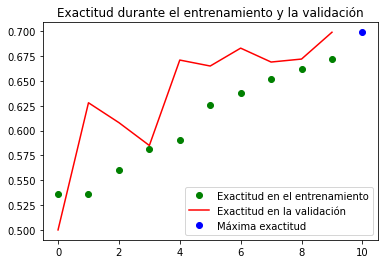

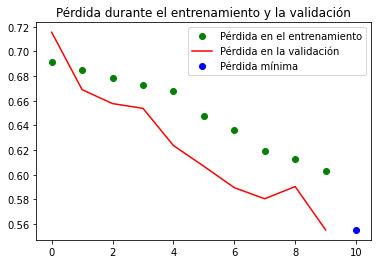

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
max_val_acc_epoch= val_acc.index(max(val_acc)) + 1
loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Exactitud en el entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Exactitud en la validación')
plt.plot(max_val_acc_epoch, max_val_acc, 'bo', label='Máxima exactitud')
plt.title('Exactitud durante el entrenamiento y la validación')
plt.legend()
print('Mejor época (exactitud) ', max_val_acc_epoch)
plt.figure()

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Pérdida mínima')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print('Mejor época (pérdida) ', min_val_loss_epoch)

plt.show()

# **Transferencia de aprendizaje / Fine-tuning**

En este caso, utilizaremos la arquitectura VGG16, sin embargo, la forma de importar las otras arquitecturas es exactamente la misma. Para más información sobre la arquitectura VGG16, por favor revisar la siguiente referencia: <br>
Karen Simonyan and Andrew Zisserman, “Very Deep Convolutional Networks for Large-Scale Image Recognition,” arXiv (2014), https://arxiv.org/abs/1409.1556.

Pagina para encontrar otros modelos similares: https://keras.io/api/applications/

In [23]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet',            # Pesos a importar (pesos de la competencia imagenet)
                  include_top=False,             # Incluir la capa de salida (Falsa)
                  input_shape=(150, 150, 3))     # Tamaño de las entradas (ancho, largo, color (RGB) --> 3)

In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [25]:
# Congelamos y descongelamos ciertas capas
# Congelamos las primeras capas para aprovechar su rendimiento desde el modelo de donde se sacaron
# La eleccion de hasta que capa utilizamos o congelamos es algo empirico
for layer in conv_base.layers:
    if layer.name[:6] == 'block5': 
      layer.trainable = True
    else:
      layer.trainable = False

In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# **Definimos la arquitectura basada en transfer learning**

In [29]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())     # Aplanar capa
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

# **Preprocesamiento de las imágenes de entrada**

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# El conjunto de validación no debe ser aumentado
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir, target_size=(150, 150), batch_size=20, class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# **Entrenamiento**

In [31]:
# Si existe un mejor modelo, se guarda el que sea cada vez mejor (Si la exactitud en el conjunto de validacion mejora)
from tensorflow.keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Modelo_2_cats_and_dogs_small_1.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=50,  # Lotes por epoca
      callbacks = [mc])     # Guardar el modelo mas mejor

Epoch 1/10
100/100 [==============================] - 23s 198ms/step - loss: 0.5420 - acc: 0.7350 - val_loss: 0.3761 - val_acc: 0.8400

Epoch 00001: val_acc improved from -inf to 0.84000, saving model to /content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Modelo_2_cats_and_dogs_small_1.h5
Epoch 2/10
100/100 [==============================] - 20s 200ms/step - loss: 0.3417 - acc: 0.8540 - val_loss: 0.3413 - val_acc: 0.8570

Epoch 00002: val_acc improved from 0.84000 to 0.85700, saving model to /content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Modelo_2_cats_and_dogs_small_1.h5
Epoch 3/10
100/100 [==============================] - 19s 193ms/step - loss: 0.3006 - acc: 0.8725 - val_loss: 0.2083 - val_acc: 0.9120

Epoch 00003: val_acc improved from 0.85700 to 0.91200, saving model to /content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Modelo_2_cats_and_dogs_small_1.h5
Epoch 4/10
100/100 [==============================] - 20s 199ms/step - loss: 0.2700 - acc: 

In [ ]:
# Se guarda el ultimo modelo, el rendimiento que se obtuvo de la ultima epoca
model.save('/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Modelo_2_cats_and_dogs_small_1.h5')

In [ ]:
# Se carga un modelo guardado en Drive, es util cuando se empieza de cero
from tensorflow.keras.models import load_model
model_saved = load_model('/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Modelo_2_cats_and_dogs_small_1.h5', compile=False)

# **Curvas de precisión y pérdida**

Mejor época (Exactitud)  6
Mejor época (Pérdida)  6


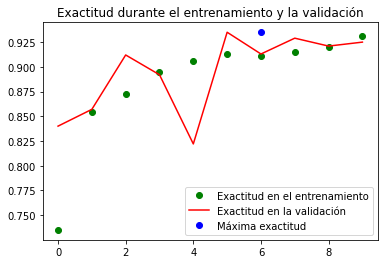

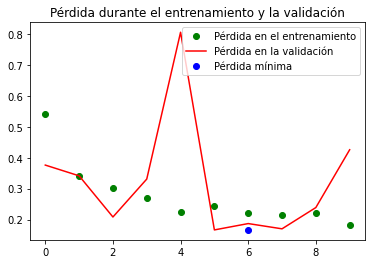

In [33]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
max_val_acc = max(val_acc)
max_val_acc_epoch= val_acc.index(max(val_acc)) + 1
loss = history.history['loss']
val_loss = history.history['val_loss']
min_val_loss = min(val_loss)
min_val_loss_epoch= val_loss.index(min(val_loss)) + 1

epochs = range(len(acc))

plt.plot(epochs, acc, 'go', label='Exactitud en el entrenamiento')
plt.plot(epochs, val_acc, 'r', label='Exactitud en la validación')
plt.plot(max_val_acc_epoch, max_val_acc, 'bo', label='Máxima exactitud')
plt.title('Exactitud durante el entrenamiento y la validación')
plt.legend()
print('Mejor época (Exactitud) ', max_val_acc_epoch)
plt.figure()

plt.plot(epochs, loss, 'go', label='Pérdida en el entrenamiento')
plt.plot(epochs, val_loss, 'r', label='Pérdida en la validación')
plt.plot(min_val_loss_epoch, min_val_loss, 'bo', label='Pérdida mínima')
plt.title('Pérdida durante el entrenamiento y la validación')
plt.legend()
print('Mejor época (Pérdida) ', min_val_loss_epoch)

plt.show()

# **Visualización de activación intermedias**

**Visualizar lo que pasa en las capas de una red neuronal convolucional**

En las siguientes celdas, se definará el código que permitirá visualizar el resultado de las salidas de las capas convolucionales y max-pooling de la segunda CNN que entrenamos (en la que aplicamos aumentación de datos).

In [38]:
from tensorflow.keras.models import load_model
#Cargamos el modelo que ya debe estar guardado en nuestro Google Drive
model = load_model('/content/drive/My Drive/Colab Notebooks/Ai Lab School/SESION 4/Modelo_cats_and_dogs_small_1.h5')
model.summary()  # As a reminder.

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [39]:
#Ruta de alguna imagen que pertenezca al conjunto de validación
img_path = '/content/cats_and_dogs_filtered/validation/dogs/dog.2104.jpg'

# Preprocesamos la imagen en un tensor 4D para ser recibida en el modelo
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
# Convertir imagen en un arreglo, por que a veces queda con un formato de objeto
img_tensor = image.img_to_array(img)
# Generar una nueva dimension para agregar el dato del numero de imagenes
img_tensor = np.expand_dims(img_tensor, axis=0)

#Recuerda que el modelo fue entrenado con imágenes
#de entrada que se preprocesaron de la siguiente manera:
# Normalizar la imagen (entrenamiento, verificacion y prueba)
img_tensor /= 255.

# Su dimensión es de (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


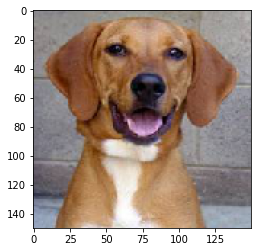

In [40]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [41]:
from tensorflow.keras import models

# Extracción de las salidas de las primeras 8 capas:
layer_outputs = [layer.output for layer in model.layers[:8]]
# Creación de un modelo que regresará estas salidas, dada una entrada:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [42]:
# Esta línea de código permite retornar una lista de 8 numpy arrays: un array por capa
activations = activation_model.predict(img_tensor)

In [43]:
#Salida de la primera capa convolucional
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


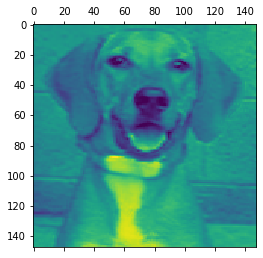

In [49]:
import matplotlib.pyplot as plt
#Visualizamos la salida representada en el cuarto mapa de características de la primera capa convolucional
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')
plt.show()

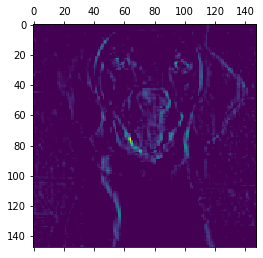

In [45]:
#Visualizamos la salida representada en el mapa de características no. 31 de la primera capa convolucional
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
plt.show()

In [46]:
import keras

# Extraemos los nombres de las capas para mostrarlos en nuestra gráfica
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Visualicemos los mapas de características
for layer_name, layer_activation in zip(layer_names, activations):
    # Este es el número de neuronas que componen el mapa de características en cuestión
    n_features = layer_activation.shape[-1]

    # Las dimensiones del mapa de características son (1, size, size, n_features)
    size = layer_activation.shape[1]

    # Concatenaremos los canales de activación (mapas de características) en esta matriz
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # Procedemos a concatenar los canales de activación dentro de un marco o rejilla
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Aplicamos un post-procesamiento a los mapas de características para que sean
            # visualmente ilustrativos
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Desplegamos la rejilla de canales de activación
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

Output hidden; open in https://colab.research.google.com to view.